# Reinforcement Learning model for forecasting spot prices

###  Libaries & Functions

In [1]:
import sys
import numpy as np
import random
from collections import deque
import numpy as np
import math
import pandas as pd
from datetime import datetime, time
import warnings
import random
import keras
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, Activation


#Jupyter visualization
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

#source: https://github.com/edwardhdlu/q-trader 

C:\Users\larsr\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
for i in range(3):
    print(i)

0
1
2


In [29]:
class Agent:
    def __init__(self, state_size ,featureSize,is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.featureSize=featureSize
        if not is_eval:
            self.model=self._model(state_size,featureSize)
        else:
            self.model=load_seq_model(model_name)

    def _model(self,windowSize,featureSize):
        model = Sequential()
        model.add(LSTM(input_shape=(windowSize, featureSize),units=100,return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50,return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=self.action_size, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')

#         model = Sequential()
#         model.add(Dense(units=64, input_shape=(windowSize,featureSize), activation="relu"))
#         model.add(Dense(units=32, activation="relu"))
#         model.add(Dense(units=8, activation="relu"))
#         model.add(Dense(self.action_size, activation="linear"))
#         model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            
            randAct=random.randrange(self.action_size)
            if randAct!=0:
                print("ran dom action ",randAct)
            return randAct

        options = self.model.predict(state)
        print("predicted by the model",np.argmax(options))
#         print(options)
        return np.argmax(options[0][0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        sample=random.sample(self.memory, batch_size)
        for i in sample:
            mini_batch.append(i)

        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
#             print(state,target_f)
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

# prints formatted price
def formatPrice(n):
    return ("-€" if n < 0 else "€") + "{0:.2f}".format(abs(n))

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_m(x):
    return 1 / (1 + np.exp(-1.0 * x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = []
#     print(n-1,len(block),d)

    for i in range(n - 2):
        res.append(sigmoid_m(block[i + 1] - block[i]))
    return np.array([res])

def getState_m(data, t, n):
    d = t - n + 1
    if d>= 0:
        block = data[d:t + 1]
    else:
        block = np.repeat(data[0:1], n, axis=0)
        block[n-t:] = data[1:n+d]
    res = []
    for i in range(n - 1):
        res.append(sigmoid_m(block[i + 1] - block[i]))
    return np.array([res])

def normalize(dataframe,ignore, scalarfile=None, save=True):
    table=dataframe[:]
    normalizer = MinMaxScaler()
    cols_normalize=list(set(dataframe.keys())-set(ignore))
    cols_renamed = [str(col)+ "_n" for col in cols_normalize]
    table[cols_renamed] = table[cols_normalize]
    if save:
        normalizer.fit(table[cols_renamed])
    else:
        normalizer = joblib.load("scalars/"+scalarfile+".save") 
    norm_df = pd.DataFrame(normalizer.transform(table[cols_renamed]), 
                                 columns=cols_renamed, 
                                 index=table.index)
    join_df = table[table.columns.difference(cols_renamed)].join(norm_df)
    table = join_df.reindex(columns = table.columns)
    if save:
        joblib.dump(normalizer, "scalars/"+scalarfile+".save")
    return table, scalarfile, cols_renamed

def save_model(model, filename):
    # serialize model to JSON
    model_json = model.to_json()
    with open("models/"+filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("models/"+filename+".h5")
    print("Saved model to disk")

def load_seq_model(filename):
    # load json and create model
    json_file = open("models/"+filename+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("models/"+filename+".h5")
    print('`load_seq_model` > model and weights loaded : ', filename)
    return loaded_model

###  Run model

In [3]:
key = 'Copper Futures Historical Data'
data = pd.read_csv("data/" + key + ".csv", delimiter=',')

data=data[['Date','Price','Vol.']]
data['Date']=pd.to_datetime(data['Date'])
data['Vol float']=data['Vol.'].apply(lambda x: str(x)[0:len(str(x))-1])
data['Vol float']=data['Vol float'].replace("",np.nan)
data['Vol.']=data['Vol float'].astype(float)
data=data.drop('Vol float',axis=1)
data['Price']=pd.to_numeric(data['Price'], errors='coerce')
data['Price']= data['Price'].interpolate()
data['Vol.']=data['Vol.'].interpolate()
data=data[1:]
data_train = data[int(0.8*len(data)):int(len(data))] # 1-1-2016 <> 12-11-2017 
data_test = data[0:int(0.2*len(data))] # 12-12-2017 <> 31-05-2018 
data_train_n, scalarfile, cols_n = normalize(data_train, [ 'Date'],"MMS_copper", save=True)
data_test_n, scalarfile, cols_n = normalize(data_test, ['Date'],"MMS_copper", save=False)
#data = list(data['PRICE']) #OLD 1D VERSION

data_train_n=data_train_n[0:1000]
data_test_n=data_test_n[0:500]

In [ ]:
import progressbar
from time import sleep
from keras import backend as K

def run_model(data, window_size=0,noOfFeatures=0, episode_count=0, batch_size=0, logtype=0, training=True,bar=False, model_name=None):
   
    K.clear_session()

    data_m = np.array(np.asmatrix(data[['Price_n', 'Vol._n']]))
    is_eval = not training
    agent = Agent(window_size,noOfFeatures,is_eval, model_name=model_name) 
    l = len(data_m) - 1
    print(l)

    total_profits=[]

    
    for e in range(episode_count):
        
        if bar:
            bar = progressbar.ProgressBar(maxval=l, \
            widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
            bar.start()
        print("Episode " + str(e+1) + "/" + str(episode_count))
        state = getState_m(data_m, 0, window_size + 1)
        total_profit = 0
        agent.inventory = []
        for t in range(l):
            if t%100==0:
                print(t,l)
            if bar:
                bar.update(t+1)
                sleep(0.1)
            action = agent.act(state)
#             print(action)
            next_state = getState_m(data_m, t + 1, window_size + 1)
            reward = 0
#             print(action)
            if action == 1: # buy
                agent.inventory.append(data['Price'].iloc[t])
                if logtype==2:
                    print("Buy: " + formatPrice(data['Price'].iloc[t]))
            elif action == 2 and len(agent.inventory) > 0: # sell
                bought_price = agent.inventory.pop(0)
                reward = max(data['Price'].iloc[t] - bought_price, 0)
                total_profit += data['Price'].iloc[t] - bought_price
                if logtype>=2:
                    print("Sell: " + formatPrice(data['Price'].iloc[t]) + " | Profit: " + formatPrice(data['Price'].iloc[t] - bought_price))
            done = True if t == l - 1 else False
            agent.memory.append((state, action, reward, next_state, done))
            state = next_state
#             print("ok before")
            if training and (len(agent.memory) > batch_size) and t%3==0:
                agent.expReplay(batch_size)
#             print("ok after")
            if done:
                if logtype>=1:
                    print("--------------------------------")
                    print("Total Profit: " + formatPrice(total_profit))
                    print("--------------------------------")
                total_profits.append(total_profit)
        if bar:
            bar.finish()

        if training:
            save_model(agent.model, "RL_Copper")
    print('Total profit after ', episode_count, ' episodes: ', np.sum(total_profits)/episode_count)
    return total_profits

total_profits =  run_model(data_train_n, window_size=15, noOfFeatures=2,episode_count=10, batch_size=32, logtype=3, training=True) #logtype 0: log end result, 1: log intermediate result, 2: log actions
# total_profits = run_model(data_test_n, 11, 1, 32, logtype=2, training=False, model_name='RL_20190125')

999
Episode 1/10
0 999
ran dom action  2
ran dom action  1
ran dom action  2
Sell: €0.81 | Profit: -€0.01
ran dom action  2
ran dom action  1
ran dom action  2
Sell: €0.81 | Profit: -€0.01
ran dom action  2
ran dom action  2
ran dom action  1
ran dom action  1
ran dom action  1
ran dom action  1
ran dom action  2
Sell: €0.76 | Profit: -€0.04
ran dom action  2
Sell: €0.76 | Profit: -€0.01
ran dom action  2
Sell: €0.74 | Profit: -€0.02
ran dom action  2
Sell: €0.74 | Profit: -€0.02
ran dom action  2
ran dom action  2
ran dom action  2
ran dom action  2
ran dom action  1
ran dom action  2
Sell: €0.75 | Profit: €0.00
ran dom action  2
ran dom action  2
ran dom action  1
ran dom action  2
Sell: €0.75 | Profit: €0.00
ran dom action  1
ran dom action  2
Sell: €0.74 | Profit: -€0.01
ran dom action  1
ran dom action  1
ran dom action  2
Sell: €0.72 | Profit: -€0.01
ran dom action  1
ran dom action  1
ran dom action  2
Sell: €0.73 | Profit: -€0.00
ran dom action  2
Sell: €0.73 | Profit: €0.01
ra

In [7]:
total_profits = run_model(data_test_n, window_size=15, noOfFeatures=2,episode_count=1, batch_size=32, logtype=2, model_name='RL_Copper',training=False)

`load_seq_model` > model and weights loaded :  RL_Copper
499
Episode 1/1
0 499
100 499
200 499
300 499
400 499
--------------------------------
Total Profit: €0.00
--------------------------------
Total profit after  1  episodes:  0.0


###  Vizualize

AttributeError: 'DataFrame' object has no attribute 'PRICE'

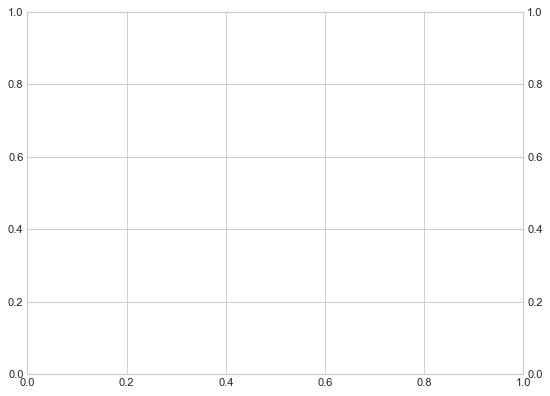

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
ax2 = ax.twinx() 

t_min = 0
t_max = 1000

data_v = data_train

ax.plot(data_v.index[t_min:t_max], data_v.PRICE[t_min:t_max], color='blue')
ax2.plot(data_v.index[t_min:t_max], data_v.LOAD_2[t_min:t_max], color='grey')
ax2.plot(data_v.index[t_min:t_max], data_v.SOLAR[t_min:t_max], color='yellow')
ax2.plot(data_v.index[t_min:t_max], data_v.WIND_ONSHORE[t_min:t_max], color='red')
ax2.plot(data_v.index[t_min:t_max], data_v.WIND_OFFSHORE[t_min:t_max], color='#FFAA55')